# VGG model

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms, datasets
from torch.utils.data import DataLoader, Dataset
from torch.autograd import Variable
from torch.utils.data import random_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, auc
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd
from sklearn.model_selection import train_test_split

# Load libraries

import torch
import numpy as np
import torch
import glob # for listing files in the directory, asemejan un patrón especificado de acuerdo con las reglas de coincidencia de Unix
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.svm import SVC
import seaborn as sns
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from torch.optim import Adam
from torch.autograd import Variable
from torch.utils.data import random_split
from torchvision import transforms
from multiprocessing import Pool
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd
import random
import cv2
import pathlib
import os

In [2]:
torch.cuda.empty_cache()

In [3]:
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

In [4]:
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import random_split
from torchvision import transforms
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd
import os

# Define a custom dataset class for the Helicobacter pylori classifier
class HPylorisDatasetClassifier(Dataset):
    def __init__(self, data_folder, annotations, specifyPaths=None, infected=0, returnLabels=True, transform=None):
        """
        Inputs: 
            DATA_FOLDER: folder that contains all folders with the annotated images.
            ANNOTATIONS: csv file that labels the input images
            SPECIFYPATHS: txt file with the paths of the images to retrieve with its corresponding label
            INFECTED: add infected (1), non-infected (-1) or all images (0) to dataset
            RETURNLABELS: return image labels (1) or not (0)
            TRANSFORM: apply any kind of torchvision transforms to the images        
        """
        self.data_folder = data_folder
        self.annotations = annotations
        self.infected = infected
        self.returnLabels = returnLabels
        self.transform = transform
        # Obtain all images from the annotations file and store them in a list
        self.images = self.obtain_all_images(self.annotations, 
                                             self.data_folder,
                                             self.infected,
                                             specifyPaths)
        
    def obtain_all_images(self, annotations, data_folder, infected, specifyPatients):
        output = []        
        if annotations != None:
            labels = pd.read_csv(annotations)
        negative_samples, positive_samples = 0, 0
        
        if specifyPatients == None:
            # Iterate over all rows in the annotations file
            for _, row in labels.iterrows():
                image_names = row['ID'].split('.')
                presence = row['Presence']
                # If we want all images or only infected/non-infected images, add the image to the list
                if infected == 0 and presence != 0:
                    image_path = os.path.join(data_folder,image_names[0], image_names[1]+'.png')
                    if os.path.exists(image_path):
                        if presence == -1:
                            if negative_samples < positive_samples:
                                output.append((image_path, 0))
                                negative_samples += 1
                        else:
                            output.append((image_path, presence))
                            positive_samples += 1       
            print(output)
            return output
        else:
            with open(specifyPatients, 'r') as file:
                specifyPatients = [tuple(line[:-1].split(',')) for line in file.readlines()]
            output = []
            for instance in specifyPatients:
                output.append((instance[0], int(instance[1])))
            print(output)
            return output

    def get_path_label(self, idx):
        # Return the image name and label at the specified index
        img_path, label = self.images[idx]
        return img_path, label

    def __len__(self):
        # Return the length of the list of images
        return len(self.images)

    def __getitem__(self, idx):
        # Get the image name and label at the specified index
        img_name, label = self.images[idx]
        try:
            # Open the image and convert it to RGB
            image = Image.open(img_name).convert('RGB')
            # Apply any specified transforms to the image
            if self.transform:
                image = self.transform(image)
            else:
                image = transforms.ToTensor(image)
            # If we want to return the labels, return the image and label
            if self.returnLabels:
                return image, label
            # Otherwise, return just the image
            else:
                return image
        except Exception as e:
            # If there was an error loading the image, print an error message and return None
            print(f"Error loading image '{img_name}': {str(e)}")
            return None

In [5]:
# Define the paths to the annotated labels and image folders
annotated_labels_path = '/fhome/mapsiv/QuironHelico/AnnotatedPatches/window_metadata.csv'
annotated_image_folders_path = '/fhome/mapsiv/QuironHelico/AnnotatedPatches/'

# Define data augmentation transforms
myTransforms = transforms.Compose([ transforms.Resize((224,224)), # Resize the image to 224x224
                                    transforms.RandomHorizontalFlip(),  # Randomly flip the image horizontally
                                    transforms.RandomVerticalFlip(),    # Randomly flip the image vertically
                                    transforms.RandomRotation(10),   # Randomly rotate the image by 10 degrees
                                    transforms.ToTensor(),       # Convert the image to a tensor
                                    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), # Normalize the image
])

SpecifyPatientsPath = '/fhome/gia01/vl_project2/randomDatasetCNN.txt'

# Create three datasets: one with all images, one with non-infected images, and one with infected images
CLF_fullDataset = HPylorisDatasetClassifier(data_folder = annotated_image_folders_path, 
                                            annotations = None,
                                            specifyPaths = SpecifyPatientsPath, 
                                            transform = myTransforms)

# Define the ratios for train, validation, and test datasets
train_ratio = 0.70
val_ratio = 0.20
test_ratio = 0.10

# Calculate the sizes of the train, validation, and test datasets
train_size = int(train_ratio * len(CLF_fullDataset))
val_size = int(val_ratio * len(CLF_fullDataset))
test_size = len(CLF_fullDataset) - train_size - val_size

# Split the full dataset into train, validation, and test datasets
train_dataset, val_dataset, test_dataset = random_split(CLF_fullDataset, [train_size, val_size, test_size])

# Create data loaders for the train, validation and test datasets

CLF_train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
CLF_val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)
CLF_test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

[('/fhome/mapsiv/QuironHelico/AnnotatedPatches/B22-70_0/00154.png', 1), ('/fhome/mapsiv/QuironHelico/AnnotatedPatches/B22-219_0/00032.png', 1), ('/fhome/mapsiv/QuironHelico/AnnotatedPatches/B22-163_0/00491.png', 1), ('/fhome/mapsiv/QuironHelico/AnnotatedPatches/B22-114_0/00112.png', 1), ('/fhome/mapsiv/QuironHelico/AnnotatedPatches/B22-304_0/00381.png', 1), ('/fhome/mapsiv/QuironHelico/AnnotatedPatches/B22-275_0/00144.png', 1), ('/fhome/mapsiv/QuironHelico/AnnotatedPatches/B22-277_0/00601.png', 1), ('/fhome/mapsiv/QuironHelico/AnnotatedPatches/B22-103_0/02245.png', 1), ('/fhome/mapsiv/QuironHelico/AnnotatedPatches/B22-170_0/01015.png', 1), ('/fhome/mapsiv/QuironHelico/AnnotatedPatches/B22-138_0/00351.png', 1), ('/fhome/mapsiv/QuironHelico/AnnotatedPatches/B22-304_0/01100.png', 1), ('/fhome/mapsiv/QuironHelico/AnnotatedPatches/B22-102_0/01468.png', 1), ('/fhome/mapsiv/QuironHelico/AnnotatedPatches/B22-138_0/00879.png', 1), ('/fhome/mapsiv/QuironHelico/AnnotatedPatches/B22-302_0/00168.pn

In [6]:
modelVGG = models.vgg16(pretrained=True)
modelVGG.classifier[6] = torch.nn.Linear(in_features=4096, out_features=2)
modelVGG.to(device)

/fhome/gia01/anaconda3/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
/fhome/gia01/anaconda3/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

# **Training**

In [7]:
loss_function = nn.CrossEntropyLoss()

optimizer = optim.Adam(modelVGG.parameters(), lr=0.0001)

In [8]:
num_epoch = 60

In [9]:
from cProfile import label
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import numpy as np

# Import the necessary modules

# FILEPATH: /fhome/gia01/vl_project2/src/CNN_classifier.ipynb
# Model training
best_accuracy = 0.0

epochs_list = list() # List of epochs

Train_loss_list = list() # Training loss list
Train_accuracy_list = list() # Accuracy list - indicates how well the model has learned to classify the training data

Val_accuracy_list = list() # Accuracy list - indicated how well the model generalizes to new, unseen data
Val_loss_list = list() # Validation loss list 

Train_true_labels = list() # label
Val_true_labels = list() # label

Train_pred_labels = list() # prediction
Val_pred_labels = list() # prediction

for epoch in range (num_epoch): # Training loop

   # Display number of actual epoch
   print("------------------------------------------------------------------------\n")
   print(f'Epoch: {epoch+1}/{num_epoch}\n')

   # Set the model to training mode, training dataset
   modelVGG.train()

   epochs_list.append(epoch + 1) # Append epoch to list

   train_accuracy = 0.0 # Accuracy of the model
   train_loss = 0.0 

   # Iterate over the training dataset
   for i, (images, labels) in enumerate(CLF_train_loader):

      # Pass images and labels to GPU
      images = images.to(device)
      labels = labels.to(device)

      optimizer.zero_grad() # Clear optimizer
      outputs = modelVGG(images) # Forward pass

      loss = loss_function(outputs, labels) # Calculate loss

      loss.backward() # Backpropagation of the loss
      optimizer.step() # Update weights of the network

      train_loss += loss.cpu().data*images.size(0) # Update train loss
      _, prediction = torch.max(outputs.data, 1)

      train_accuracy += int(torch.sum(prediction == labels.data)) # Update train accuracy

      # Calculate confusion matrix

   train_accuracy = train_accuracy / train_size # Get the accuracy
   Train_accuracy_list.append(train_accuracy) # Append train accuracy to list

   train_loss = train_loss / train_size # Get the loss
   Train_loss_list.append(train_loss) # Append loss to list

   val_accuracy = 0.0 # Accuracy of the model
   val_loss = 0.0 # Loss of the model

   # Set the model to evaluation mode, validation dataset
   modelVGG.eval()

   # Iterate over the validation dataset
   for i, (images, labels) in enumerate(CLF_val_loader):

      # Pass images and labels to GPU
      images = images.to(device)
      labels = labels.to(device)

      outputs = modelVGG(images) # Forward pass
      loss = loss_function(outputs, labels) # Calculate loss

      val_loss += loss.cpu().data*images.size(0) # Update validation loss

      _, prediction = torch.max(outputs.data, 1)
      val_accuracy += int(torch.sum(prediction == labels.data)) # Update validation accuracy

      # Calculate confusion matrix

   val_accuracy = val_accuracy / val_size # Get the accuracy
   Val_accuracy_list.append(val_accuracy) # Append validation accuracy to list

   val_loss = val_loss / val_size # Get the loss
   Val_loss_list.append(val_loss) # Append loss to list

   print(f'Epoch: {epoch + 1}, Train Loss: {train_loss}, Train Accuracy: {train_accuracy}, Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}\n')

   # Save the best model
   if (val_accuracy > best_accuracy): 

      # Save model
      torch.save(modelVGG.state_dict(), 'best_checkpoint.model')
      best_accuracy = val_accuracy # Update best accuracy


------------------------------------------------------------------------

Epoch: 1/60

Epoch: 1, Train Loss: 0.6493672728538513, Train Accuracy: 0.6194690265486725, Validation Loss: 0.30012181401252747, Validation Accuracy: 0.875

------------------------------------------------------------------------

Epoch: 2/60

Epoch: 2, Train Loss: 0.2900994122028351, Train Accuracy: 0.8938053097345132, Validation Loss: 0.0595964714884758, Validation Accuracy: 0.96875

------------------------------------------------------------------------

Epoch: 3/60

Epoch: 3, Train Loss: 0.23805475234985352, Train Accuracy: 0.9292035398230089, Validation Loss: 0.175615593791008, Validation Accuracy: 0.9375

------------------------------------------------------------------------

Epoch: 4/60

Epoch: 4, Train Loss: 0.062470126897096634, Train Accuracy: 0.9646017699115044, Validation Loss: 0.0443587489426136, Validation Accuracy: 0.96875

------------------------------------------------------------------------

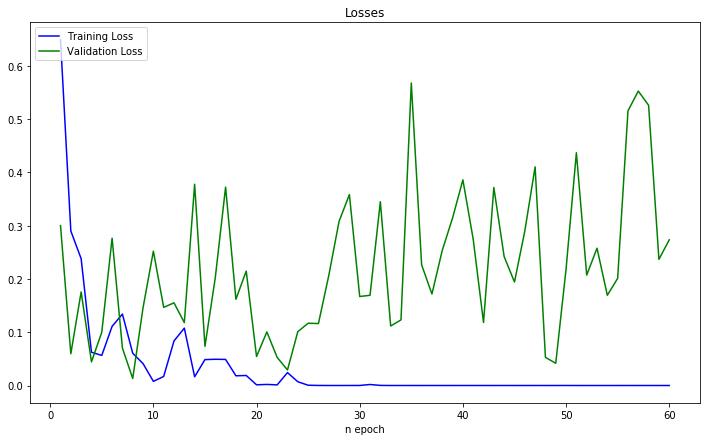

In [10]:
# Training loss plot

plt.rcParams['figure.figsize'] = [12, 7] # Set the size of the plot

plt.title('Losses')
plt.plot(epochs_list, Train_loss_list, "-b", label = 'Training Loss')
plt.plot(epochs_list, Val_loss_list, "-g", label = 'Validation Loss')
plt.xlabel("n epoch")
plt.legend(loc = 'upper left')
plt.show()

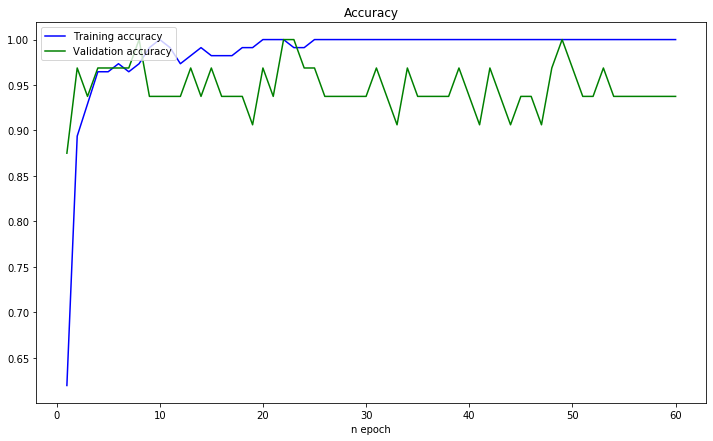

Average training accuracy: 0.9853982300884956
Average validation accuracy: 0.946875


In [11]:
# Accuracy plot 
plt.plot(epochs_list, Train_accuracy_list, "-b", label = 'Training accuracy')
plt.plot(epochs_list, Val_accuracy_list, "-g", label = 'Validation accuracy')
plt.xlabel("n epoch")
plt.legend(loc = 'upper left')
plt.title('Accuracy')
plt.show()

print("Average training accuracy:", sum(Train_accuracy_list) / len(Train_accuracy_list) ) # Training accuracy
print("Average validation accuracy:", sum(Val_accuracy_list) / len(Val_accuracy_list)) # Validation accuracy

In [12]:
"""
num_splits = 5  # Number of folds for cross-validation
kfold = KFold(n_splits=num_splits, shuffle=True, random_state=42) # Define K fold
"""

'\nnum_splits = 5  # Number of folds for cross-validation\nkfold = KFold(n_splits=num_splits, shuffle=True, random_state=42) # Define K fold\n'

In [13]:
"""
from sklearn.metrics import classification_report

# Define the train function
def train(model, CLF_train_loader, CLF_val_loader, num_epoch, loss_function, optimizer, device):

    # Model training
    best_accuracy = 0.0
    patience = 5 # Number of epoch to wait for improvement
    stop_early = 0 # Counter for early stopping

    epochs_list = list() # List of epochs

    Train_loss_list = list() # Training loss list
    Train_accuracy_list = list() # Accuracy list - indicates how well the model has learned to classify the training data

    Val_accuracy_list = list() # Accuracy list - indicated how well the model generalizes to new, unseen data
    Val_loss_list = list() # Validation loss list 

    for epoch in range (num_epoch): # Training loop

        # Display number of actual epoch
        print("------------------------------------------------------------------------\n")
        print(f'Epoch: {epoch+1}/{num_epoch}\n')

        # Set the model to training mode, training dataset
        modelVGG.train()

        epochs_list.append(epoch + 1) # Append epoch to list

        train_accuracy = 0.0 # Accuracy of the model
        train_loss = 0.0 

        # Iterate over the training dataset
        for i, (images, labels) in enumerate(CLF_train_loader):

            # Pass images and labels to GPU
            images = images.to(device)
            labels = labels.to(device)

            optimizer.zero_grad() # Clear optimizer
            outputs = modelVGG(images) # Forward pass

            loss = loss_function(outputs, labels) # Calculate loss

            loss.backward() # Backpropagation of the loss
            optimizer.step() # Update weights of the network

            train_loss += loss.cpu().data*images.size(0) # Update train loss
            _, prediction = torch.max(outputs.data, 1)

            train_accuracy += int(torch.sum(prediction == labels.data)) # Update train accuracy

        train_accuracy = train_accuracy / train_size # Get the accuracy
        Train_accuracy_list.append(train_accuracy) # Append train accuracy to list

        train_loss = train_loss / train_size # Get the loss
        Train_loss_list.append(train_loss) # Append loss to list

        val_accuracy = 0.0 # Accuracy of the model

        # Set the model to evaluation mode, validation dataset
        modelVGG.eval()

        val_loss = 0.0 # Loss of the model

        # Iterate over the validation dataset
        for i, (images, labels) in enumerate(CLF_val_loader):

            # Pass images and labels to GPU
            images = images.to(device)
            labels = labels.to(device)

            outputs = modelVGG(images) # Forward pass
            loss = loss_function(outputs, labels) # Calculate loss

            val_loss += loss.cpu().data*images.size(0) # Update validation loss

        val_loss = val_loss / val_size # Get the loss
        Val_loss_list.append(val_loss) # Append loss to list

        print(f'Epoch: {epoch}, Train Loss: {train_loss}, Train Accuracy: {train_accuracy}, Validation accuracy Accuracy: {val_accuracy}\n')

        # Check if validation loss has improved
        best_loss = float('inf') # initialize best_loss to infinity
        if val_loss < best_loss:
            best_loss = val_loss
            stop_early = 0
            # Save the best model
            torch.save(model.state_dict(), 'best_checkpoint.model')
        else:
            stop_early += 1
            if stop_early >= patience:
                print("Early stopping")
                break
            best_loss = val_loss
            stop_early = 0
            # Save the best model
            torch.save(model.state_dict(), 'best_checkpoint.model')

    return Train_loss_list, Val_loss_list

train_losses = list() # List to store the training losses of all folds
val_losses = list() # List to store the validation losses of all folds

for fold, (train_indices, val_indices) in enumerate(kfold.split(CLF_fullDataset)):

    print(f"\nFold {fold + 1}/{num_splits}\n") # Display the count of actual fold

    # Define the ratios for train, validation, and test datasets
    train_ratio = 0.7
    val_ratio = 0.20
    test_ratio = 0.10

    # Calculate the sizes of the train, validation, and test datasets
    train_size = int(train_ratio * len(CLF_fullDataset))
    val_size = int(val_ratio * len(CLF_fullDataset))
    test_size = len(CLF_fullDataset) - train_size - val_size

    # Split the full dataset into train, validation, and test datasets
    train_dataset, val_dataset, test_dataset = random_split(CLF_fullDataset, [train_size, val_size, test_size])

    # Create data loaders for the train and validation datasets
    CLF_train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
    CLF_val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)
    CLF_test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

    # Create model
    modelVGG = models.vgg16(pretrained=True)
    modelVGG.classifier[6] = torch.nn.Linear(in_features=4096, out_features=2)
    modelVGG.to(device)

    # Pass model to GPU
    # Optimizer
    optimizer = torch.optim.Adam(modelVGG.parameters(), lr=0.001, weight_decay=0.0001)
    # Loss function
    loss_function = nn.CrossEntropyLoss()

    # K fold training loop
    tran_loss, val_loss = train(model = modelVGG, CLF_train_loader = CLF_train_loader, 
                                CLF_val_loader = CLF_val_loader, num_epoch = num_epoch,
                                loss_function = loss_function, optimizer = optimizer, 
                                device = device)

    train_losses.append(train_loss) # Append a list of train losses for the current fold
    val_losses.append(val_loss) # Append a list of validation losses for the current fold

    plt.rcParams['figure.figsize'] = [12, 7] # Set the size of the plot

    plt.plot(train_loss, label = f'Training loss. Fold: {fold + 1}')
    plt.plot(val_loss, label = f'Validation loss. Fold: {fold + 1}')
    plt.xlabel("n epoch")
    plt.legend(loc = 'upper right')
    plt.title(f'Training and Validation Loss Curves with K fold')
    plt.show
"""


'\nfrom sklearn.metrics import classification_report\n\n# Define the train function\ndef train(model, CLF_train_loader, CLF_val_loader, num_epoch, loss_function, optimizer, device):\n\n    # Model training\n    best_accuracy = 0.0\n    patience = 5 # Number of epoch to wait for improvement\n    stop_early = 0 # Counter for early stopping\n\n    epochs_list = list() # List of epochs\n\n    Train_loss_list = list() # Training loss list\n    Train_accuracy_list = list() # Accuracy list - indicates how well the model has learned to classify the training data\n\n    Val_accuracy_list = list() # Accuracy list - indicated how well the model generalizes to new, unseen data\n    Val_loss_list = list() # Validation loss list \n\n    for epoch in range (num_epoch): # Training loop\n\n        # Display number of actual epoch\n        print("------------------------------------------------------------------------\n")\n        print(f\'Epoch: {epoch+1}/{num_epoch}\n\')\n\n        # Set the model to 

### **Confusion Matrix**

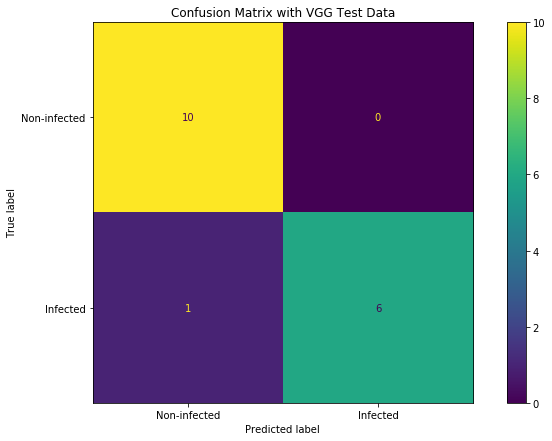

In [14]:
y_true = []
y_pred = []
with torch.no_grad():
    for data in CLF_test_loader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        outputs = modelVGG(images)
        _, predicted = torch.max(outputs.data, 1)
        y_true.append(labels.cpu().numpy())
        y_pred.append(predicted.cpu().numpy())
y_true = np.concatenate(y_true)
y_pred = np.concatenate(y_pred)
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Non-infected', 'Infected'])
disp.plot()
plt.title('Confusion Matrix with VGG Test Data')
plt.savefig('confusion_matrix_VGG2.png')
plt.show()

### **Classification Report**

In [15]:
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred, target_names=['Non-infected', 'Infected']))

              precision    recall  f1-score   support

Non-infected       0.91      1.00      0.95        10
    Infected       1.00      0.86      0.92         7

    accuracy                           0.94        17
   macro avg       0.95      0.93      0.94        17
weighted avg       0.95      0.94      0.94        17



# **Patient Evaluation**

In [16]:
# Initialize the dictionary to store the data
data_dict = {'INFECTED': {}, 'NOT_INFECTED': {}}

# Read the file line by line
with open('/fhome/gia01/vl_project2/autoencoder/txt files/train_thresholds.txt', 'r') as file:
    for line in file:
        # Strip any whitespace and split the line by comma
        parts = line.strip().split(',')
        # Assign the parts to variables for clarity
        sample_id, path, status = parts[0], parts[1], int(parts[2])
        # Depending on the status, add the entry to the respective dictionary key
        if status == 1:
            data_dict['INFECTED'][sample_id] = path
        else:
            data_dict['NOT_INFECTED'][sample_id] = path

# Now data_dict is populated with the data in the format you wanted.
print(data_dict)

{'INFECTED': {'B22-65': '/fhome/mapsiv/QuironHelico/CroppedPatches/B22-65_1/', 'B22-222': '/fhome/mapsiv/QuironHelico/CroppedPatches/B22-222_1/', 'B22-130': '/fhome/mapsiv/QuironHelico/CroppedPatches/B22-130_1/', 'B22-225': '/fhome/mapsiv/QuironHelico/CroppedPatches/B22-225_1/', 'B22-263': '/fhome/mapsiv/QuironHelico/CroppedPatches/B22-263_1/', 'B22-39': '/fhome/mapsiv/QuironHelico/CroppedPatches/B22-39_1/', 'B22-169': '/fhome/mapsiv/QuironHelico/CroppedPatches/B22-169_1/', 'B22-75': '/fhome/mapsiv/QuironHelico/CroppedPatches/B22-75_1/', 'B22-49': '/fhome/mapsiv/QuironHelico/CroppedPatches/B22-49_1/', 'B22-82': '/fhome/mapsiv/QuironHelico/CroppedPatches/B22-82_1/', 'B22-159': '/fhome/mapsiv/QuironHelico/CroppedPatches/B22-159_1/', 'B22-96': '/fhome/mapsiv/QuironHelico/CroppedPatches/B22-96_1/', 'B22-255': '/fhome/mapsiv/QuironHelico/CroppedPatches/B22-255_1/', 'B22-310': '/fhome/mapsiv/QuironHelico/CroppedPatches/B22-310_1/', 'B22-105': '/fhome/mapsiv/QuironHelico/CroppedPatches/B22-10

In [17]:
checkpoint = torch.load("best_checkpoint.modelVGG") # Load checkpoint

modelVGG = models.vgg16(pretrained=True)
modelVGG.classifier[6] = torch.nn.Linear(in_features=4096, out_features=2)
modelVGG.load_state_dict(checkpoint) # Load checkpoint into the model
modelVGG.to(device)
modelVGG.eval() # Set model to evaluation mode


/fhome/gia01/anaconda3/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
/fhome/gia01/anaconda3/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [18]:
# Empty list in which the predictions of the model will be saved
VGG_predictions = list()

In [19]:
# Define data augmentation transforms
myTransforms = transforms.Compose([ transforms.Resize((224,224)), # Resize the image to 224x224
                                    transforms.ToTensor(),       # Convert the image to a tensor
                                    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), # Normalize the image
])

In [20]:
from PIL import Image

def prediction(img_path, myTransforms):
    # Load the image
    image = Image.open(img_path)
    
    # Convert RGBA to RGB if necessary
    if image.mode == 'RGBA':
        image = image.convert('RGB')

    # Apply the transformations
    image_tensor = myTransforms(image).unsqueeze(0).to(device)

    # Ensure the model is on the same device as the data
    modelVGG.to(device)

    # Get the model's output
    output = modelVGG(image_tensor)

    # Move the output to CPU and then convert it to a numpy array
    output = output.cpu().data.numpy()

    # Use numpy's argmax to get the index of the maximum value
    index = output.argmax()

    return index


In [21]:
# Declaration of the function in order to make the conversion
def calculate_confidence(percentage, threshold):
    """
    Calculate the confidence level based on a given percentage using a rule of three.

    Parameters:
    percentage (float): A percentage value where 0.1 maps to a confidence level of 1.

    Returns:
    float: The calculated confidence level, capped at 1 for percentages over 0.1.
    """
    # If the percentage is greater than 0.1, the confidence is 1
    if percentage >= threshold:
        return 1
    else:
        # Otherwise, scale the confidence linearly from 0 to 1 as the percentage goes from 0 to 0.1
        # Using the rule of three: percentage / 0.1 = confidence / 1
        confidence = percentage / threshold
        return confidence

In [22]:
def process_patient(image_path):
    # Get the prediction for the patch
    pred = prediction(image_path, myTransforms)
    return pred

In [23]:
y_scores001 = list() # Store the probability estimates of being from the infected class, threshold: %1
y_scores002 = list() # Store the probability estimates of being from the infected class, threshold: %2
y_scores0025 = list() # Store the probability estimates of being from the infected class, threshold: %2.5
y_scores003 = list() # Store the probability estimates of being from the infected class, threshold: %3
y_scores0035 = list() # Store the probability estimates of being from the infected class, threshold: %3.5
y_scores004 = list() # Store the probability estimates of being from the infected class, threshold: %4
y_scores005 = list() # Store the probability estimates of being from the infected class, threshold: %5
y_scores007 = list() # Store the probability estimates of being from the infected class, threshold: %7
y_scores015 = list() # Store the probability estimates of being from the infected class, threshold: %15
y_scores050 = list() # Store the probability estimates of being from the infected class, threshold: %50
y_scores075 = list() # Store the probability estimates of being from the infected class, threshold: %75
y_scores090 = list() # Store the probability estimates of being from the infected class, threshold: %90

infectedPer_list = list() # Store the infected percentage for each patient

y_test = list() # Store the ground truth from the data, infected or not infected

i = 0 # Counter

# Iterate over the test set
for label in data_dict:

    patients_dict = data_dict[label] # Get the dictionary of the patients

    # Determine ground truth
    if (label == "INFECTED"): # Infected
        gt = 1
    
    else: # Not infected
        gt = 0

    # Iterate over the patients
    for patient in patients_dict:

        patient_predictions = list() # Initialize the data structure in which the prediction for a particular patient will be stored
        # Get a list of all the full paths for the images from the patient
        images_files_full_paths = [os.path.join(patients_dict[patient], file) for file in os.listdir(patients_dict[patient])]

        """
        if __name__ == '__main__':

            with Pool() as p:
                # Use the map function to distribute the work among the worker processes
                patient_predictions = p.map(process_patient, images_files_full_paths)
        """
        
        # Iterate over all the images of the patient
        for image_path in images_files_full_paths:

            pred = prediction(image_path, myTransforms) # Get the prediction for the patch
            patient_predictions.append(pred) # Append the prediction

        value = 1 # Infected class

        # Calculate the percentage of infected detected patches for a particular patient
        infected_percentage = patient_predictions.count(value) / len(patient_predictions)

        infectedPer_list.append(infected_percentage)

        # Calculate the estimated probability of the model based on predefined criterion for the diagnosis
        # += threshold of infected patches in a patient - estimated probability of infection: 100%
        # 0% of infected patches in a patient - estimated probability of infection: 0%
        y_score001 = calculate_confidence(infected_percentage, 0.01) # Threshold: %1
        y_score002 = calculate_confidence(infected_percentage, 0.02) # Threshold: %2
        y_score0025 = calculate_confidence(infected_percentage, 0.025) # Threshold: %2.5
        y_score003 = calculate_confidence(infected_percentage, 0.03) # Threshold: %3
        y_score0035 = calculate_confidence(infected_percentage, 0.035) # Threshold: %3.5
        y_score004 = calculate_confidence(infected_percentage, 0.04) # Threshold: %4
        y_score005 = calculate_confidence(infected_percentage, 0.05) # Threshold: %5
        y_score007 = calculate_confidence(infected_percentage, 0.07) # Threshold: %7
        y_score015 = calculate_confidence(infected_percentage, 0.15) # Threshold: %15
        y_score050 = calculate_confidence(infected_percentage, 0.50) # Threshold: %50
        y_score075 = calculate_confidence(infected_percentage, 0.75) # Threshold: %75
        y_score090 = calculate_confidence(infected_percentage, 0.90) # Threshold: %90
        
        # Update y_score and y_test lists
        y_scores001.append(y_score001)
        y_scores002.append(y_score002)
        y_scores0025.append(y_score0025)
        y_scores003.append(y_score003)
        y_scores0035.append(y_score0035)
        y_scores004.append(y_score004)
        y_scores005.append(y_score005)
        y_scores007.append(y_score007)
        y_scores015.append(y_score015)
        y_scores050.append(y_score050)
        y_scores075.append(y_score075)
        y_scores090.append(y_score090)

        y_test.append(gt) # Ground truth

        i += 1
        print("Patient", str(i) + ":", "for 0.01  |", gt, "-", round(y_score001, 3))
        print("Patient", str(i) + ":", "for 0.02  |", gt, "-", round(y_score002, 3))
        print("Patient", str(i) + ":", "for 0.025 |", gt, "-", round(y_score0025, 3))
        print("Patient", str(i) + ":", "for 0.03  |", gt, "-", round(y_score003, 3))
        print("Patient", str(i) + ":", "for 0.035 |", gt, "-", round(y_score0035, 3))
        print("Patient", str(i) + ":", "for 0.04  |", gt, "-", round(y_score004, 3))
        print("Patient", str(i) + ":", "for 0.05  |", gt, "-", round(y_score005, 3))
        print("Patient", str(i) + ":", "for 0.07  |", gt, "-", round(y_score007, 3))
        print("Patient", str(i) + ":", "for 0.15  |", gt, "-", round(y_score015, 3))
        print("Patient", str(i) + ":", "for 0.50  |", gt, "-", round(y_score050, 3))
        print("Patient", str(i) + ":", "for 0.75  |", gt, "-", round(y_score075, 3))
        print("Patient", str(i) + ":", "for 0.90  |", gt, "-", round(y_score090, 3))
        print()

        # print(y_scores) # Display scores
        # print(y_test) # Display ground truth

        # Update control data structure
        # CNN_predictions.append((str(patient), [gt, y_score]))

Patient 1: for 0.01  | 1 - 1
Patient 1: for 0.02  | 1 - 1
Patient 1: for 0.025 | 1 - 1
Patient 1: for 0.03  | 1 - 1
Patient 1: for 0.035 | 1 - 1
Patient 1: for 0.04  | 1 - 1
Patient 1: for 0.05  | 1 - 1
Patient 1: for 0.07  | 1 - 1
Patient 1: for 0.15  | 1 - 0.846
Patient 1: for 0.50  | 1 - 0.254
Patient 1: for 0.75  | 1 - 0.169
Patient 1: for 0.90  | 1 - 0.141

Patient 2: for 0.01  | 1 - 1
Patient 2: for 0.02  | 1 - 1
Patient 2: for 0.025 | 1 - 1
Patient 2: for 0.03  | 1 - 1
Patient 2: for 0.035 | 1 - 1
Patient 2: for 0.04  | 1 - 1
Patient 2: for 0.05  | 1 - 1
Patient 2: for 0.07  | 1 - 1
Patient 2: for 0.15  | 1 - 1
Patient 2: for 0.50  | 1 - 0.783
Patient 2: for 0.75  | 1 - 0.522
Patient 2: for 0.90  | 1 - 0.435

Patient 3: for 0.01  | 1 - 1
Patient 3: for 0.02  | 1 - 1
Patient 3: for 0.025 | 1 - 1
Patient 3: for 0.03  | 1 - 1
Patient 3: for 0.035 | 1 - 1
Patient 3: for 0.04  | 1 - 1
Patient 3: for 0.05  | 1 - 1
Patient 3: for 0.07  | 1 - 1
Patient 3: for 0.15  | 1 - 0.779
Patient 3

In [24]:
binary_labels001 = [1 if prob >= 0.5 else 0 for prob in y_scores001] # Threshold: %1
binary_labels002 = [1 if prob >= 0.5 else 0 for prob in y_scores002] # Threshold: %2
binary_labels0025 = [1 if prob >= 0.5 else 0 for prob in y_scores0025] # Threshold: %2.5
binary_labels003 = [1 if prob >= 0.5 else 0 for prob in y_scores003] # Threshold: %3
binary_labels0035 = [1 if prob >= 0.5 else 0 for prob in y_scores0035] # Threshold: %3.5
binary_labels004 = [1 if prob >= 0.5 else 0 for prob in y_scores004] # Threshold: %4
binary_labels005 = [1 if prob >= 0.5 else 0 for prob in y_scores005] # Threshold: %5
binary_labels007 = [1 if prob >= 0.5 else 0 for prob in y_scores007] # Threshold: %7
binary_labels015 = [1 if prob >= 0.5 else 0 for prob in y_scores015] # Threshold: %15
binary_labels050 = [1 if prob >= 0.5 else 0 for prob in y_scores050] # Threshold: %50
binary_labels075 = [1 if prob >= 0.5 else 0 for prob in y_scores075] # Threshold: %75
binary_labels090 = [1 if prob >= 0.5 else 0 for prob in y_scores090] # Threshold: %90

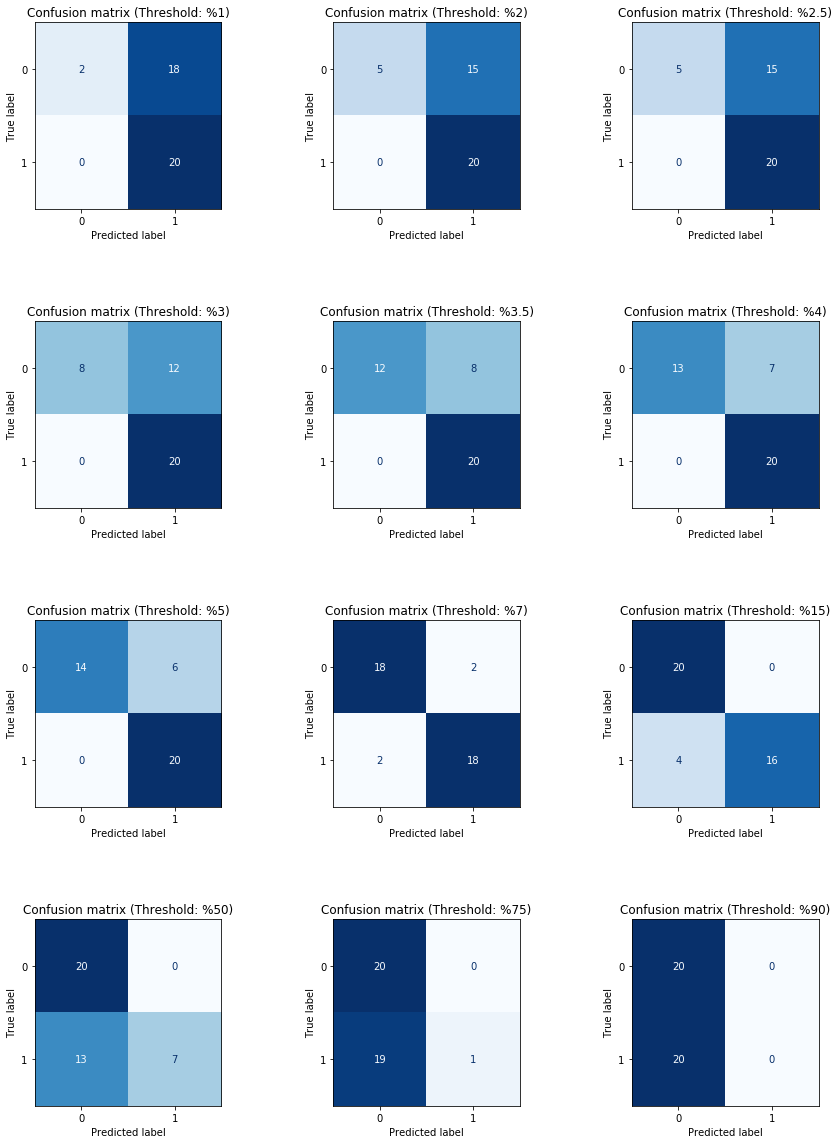

In [25]:
# Assuming you have binary_labels0025, binary_labels0035, binary_labels004, binary_labels005, etc. already defined
# Define the thresholds for each binary label
thresholds = ['%1', '%2', '%2.5', '%3', '%3.5', '%4', '%5', '%7', '%15', '%50', '%75', '%90']
# Store all the binary labels in a list
binary_labels_list = [binary_labels001, binary_labels002, binary_labels0025, binary_labels003, binary_labels0035, binary_labels004, binary_labels005, binary_labels007, binary_labels015, binary_labels050, binary_labels075, binary_labels090]
# In order to store the true negative, false positive, false negative and true positive
ravels = list()

# Set the number of subplots based on the number of thresholds
n_cols = 3
n_rows = int(np.ceil(len(thresholds) / n_cols))

# Create a figure to hold all the subplots
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(n_cols * 4, n_rows * 4))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Loop through the thresholds and plot each confusion matrix
for i, threshold in enumerate(thresholds):
    # Compute confusion matrix
    cm = confusion_matrix(y_test, binary_labels_list[i])
    # Unpack the confusion matrix into true negative, false positive, false negative and true positive
    true_neg, false_pos, false_neg, true_pos = cm.ravel()
    # Store the ravel in a list
    ravel = [true_neg, false_pos, false_neg, true_pos]
    ravels.append(ravel)
    
    # Initialize the display object
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["0", "1"])

    # Plot in the next subplot
    disp.plot(ax=axes[i], cmap='Blues', colorbar=False)
    axes[i].set_title(f'Confusion matrix (Threshold: {threshold})')

# Hide any unused subplots
for ax in axes[len(thresholds):]:
    ax.axis('off')

# Adjust layout to prevent overlap
plt.tight_layout()

# Add more space between the plots
plt.subplots_adjust(wspace=0.4, hspace=0.6)

# Show the plot
plt.show()

# **ROC Curve**

The accuracy of the model with a threshold of %1 is 0.55
The area under the ROC curve (AUC) for threshold %1 is 0.55

The accuracy of the model with a threshold of %2 is 0.62
The area under the ROC curve (AUC) for threshold %2 is 0.62

The accuracy of the model with a threshold of %2.5 is 0.62
The area under the ROC curve (AUC) for threshold %2.5 is 0.62

The accuracy of the model with a threshold of %3 is 0.70
The area under the ROC curve (AUC) for threshold %3 is 0.70

The accuracy of the model with a threshold of %3.5 is 0.80
The area under the ROC curve (AUC) for threshold %3.5 is 0.80

The accuracy of the model with a threshold of %4 is 0.82
The area under the ROC curve (AUC) for threshold %4 is 0.82

The accuracy of the model with a threshold of %5 is 0.85
The area under the ROC curve (AUC) for threshold %5 is 0.85

The accuracy of the model with a threshold of %7 is 0.90
The area under the ROC curve (AUC) for threshold %7 is 0.90

The accuracy of the model with a threshold of %1

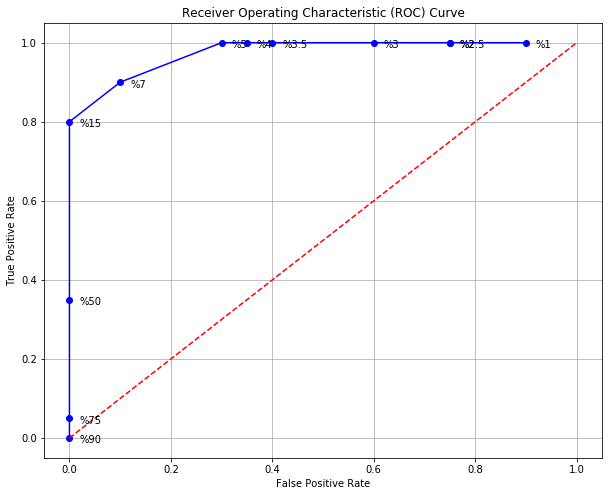

In [26]:
# Lists to hold all TPRs and FPRs
TPRs = []
FPRs = []
AUCs = []

# Iterate over each threshold and corresponding confusion matrix ravel to calculate TPR and FPR
for i, threshold in enumerate(thresholds):
    true_neg, false_pos, false_neg, true_pos = ravels[i]

    # Calculate TPR and FPR
    TPR = true_pos / (true_pos + false_neg) if (true_pos + false_neg) != 0 else 0
    FPR = false_pos / (false_pos + true_neg) if (false_pos + true_neg) != 0 else 0

    TPRs.append(TPR)
    FPRs.append(FPR)

    # Calculate AUC for ROC curve
    AUC = auc([0, FPR, 1], [0, TPR, 1])
    AUCs.append(AUC)

    print(f"The accuracy of the model with a threshold of {threshold} is {(true_pos + true_neg) / (true_pos + true_neg + false_pos + false_neg):.2f}")
    print(f"The area under the ROC curve (AUC) for threshold {threshold} is {AUC:.2f}")
    print()

# Plot the ROC curve
plt.figure(figsize=(10, 8))
plt.plot(FPRs, TPRs, marker='o', linestyle='-', color='blue')
plt.plot([0, 1], [0, 1], linestyle='--', color='red')  # Random chance line

# Annotate each point on the ROC curve with its threshold
for i, threshold in enumerate(thresholds):
    plt.annotate(threshold, (FPRs[i], TPRs[i]), textcoords="offset points", xytext=(10,-5))

plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)
plt.show()